<a href="https://colab.research.google.com/github/cabamarcos/GANs_VA/blob/main/Notebooks/GANsFC_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)



In [3]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 200

Using cuda


In [4]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [5]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logsFC/fake")
writer_real = SummaryWriter(f"logsFC/real")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4513179.42it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 65322.65it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1274925.38it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8815607.94it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [6]:
step = 0
list_lossg=[]
list_lossd=[]

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        # Append losses to the lists
        list_lossd.append(lossD.item())
        list_lossg.append(lossG.item())

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/200] Batch 0/1875                       Loss D: 0.6923, loss G: 0.7115
Epoch [1/200] Batch 0/1875                       Loss D: 0.4433, loss G: 1.0912
Epoch [2/200] Batch 0/1875                       Loss D: 0.8214, loss G: 0.6405
Epoch [3/200] Batch 0/1875                       Loss D: 0.5993, loss G: 0.8929
Epoch [4/200] Batch 0/1875                       Loss D: 0.2309, loss G: 1.8760
Epoch [5/200] Batch 0/1875                       Loss D: 0.5633, loss G: 1.0580
Epoch [6/200] Batch 0/1875                       Loss D: 0.7037, loss G: 0.8422
Epoch [7/200] Batch 0/1875                       Loss D: 0.7244, loss G: 1.0120
Epoch [8/200] Batch 0/1875                       Loss D: 0.3592, loss G: 1.4201
Epoch [9/200] Batch 0/1875                       Loss D: 0.6019, loss G: 1.4477
Epoch [10/200] Batch 0/1875                       Loss D: 0.6120, loss G: 1.2648
Epoch [11/200] Batch 0/1875                       Loss D: 0.8125, loss G: 0.8698
Epoch [12/200] Batch 0/1875           

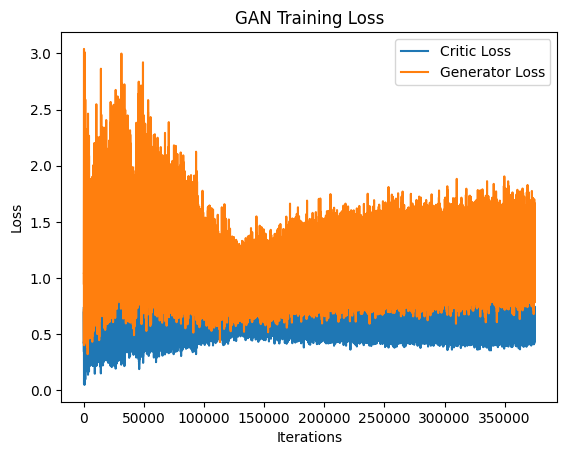

In [8]:
import matplotlib.pyplot as plt

# Plot the losses
plt.plot(list_lossd, label='Critic Loss')
plt.plot(list_lossg, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.show()

In [ ]:
import shutil

# Define la ruta de la carpeta que quieres mover desde Google Colab
ruta_carpeta_colab = '/content/logsFC'

# Define la ruta de destino en tu Google Drive
ruta_destino_drive = '/content/drive/My Drive/GANS/'

# Mueve la carpeta a tu Google Drive
shutil.move(ruta_carpeta_colab, ruta_destino_drive)